# Tutorial \#3: Blach Hole and Accretion Disk Parameters

**Nicolás Guerra-Varas**
Professor Dragana Ilić
Tutor Isidora Jankov

Date: 

Data: sample of 500 SDSS quasars (QSOs) with spectral parameters from __[Shen et al. 2011
](https://ui.adsabs.harvard.edu/abs/2011ApJS..194...45S/abstract)__ (__[VizieR catalog](https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/ApJS/194/45)__).

The goal of this tutorial is to learn how to estimate the mass of the black hole (BH) of active galactic nuclei (AGN) with indirect methods: scaling relationships from reverberation mapping (RM) and the use of the bulge luminosity of the host galaxy.

---

## Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')

import seaborn as sns
sns.set_theme()
sns.set_context('paper')

from collections import Counter

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

## Preparing the data

In [3]:
qsos = pd.read_csv('shen_subsample_500.csv')
qsos.reset_index(inplace=True, drop=True)
qsos

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,logLbol,e_logLbol,logLBHb,e_logLBHb,W_BHb_,e_W_BHb_,EWBHb,e_EWBHb,SN_Hb_,logBH,e_logBH,logEdd
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,4399.3,330.1,62.0,3.1,23.06,8.33,0.07,-1.20
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,2371.4,541.6,89.4,8.7,15.06,7.59,0.20,-0.87
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,10756.6,4366.4,32.1,3.4,16.27,9.05,0.35,-2.03
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,15241.3,362.8,118.7,6.3,19.79,9.36,0.02,-2.33
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,1385.6,48.6,52.5,2.9,15.96,7.29,0.03,-0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,231.08040,27.95578,1846,28,54173,-23.33,45.423,0.005,42.56,0.02,9345.2,348.3,60.6,3.4,24.76,9.08,0.03,-1.76
496,231.09229,26.70657,2160,444,53885,-22.72,44.989,0.005,42.19,0.04,4363.7,503.4,73.2,6.8,17.34,8.20,0.10,-1.31
497,231.11946,30.54376,1650,545,53174,-24.56,45.891,0.001,43.14,0.01,2572.5,106.9,76.1,1.9,40.15,8.19,0.04,-0.40
498,231.12225,35.25613,1354,466,52814,-22.60,45.143,0.005,41.80,0.05,1559.7,243.2,21.0,2.7,15.44,7.38,0.14,-0.34


In [4]:
qsos.shape

(500, 18)

In [5]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'logLbol',
       'e_logLbol', 'logLBHb', 'e_logLBHb', 'W_BHb_', 'e_W_BHb_', 'EWBHb',
       'e_EWBHb', 'SN_Hb_', 'logBH', 'e_logBH', 'logEdd'],
      dtype='object')

The columns have the following information:
* `RAJ2000`, `DEJ2000`: right ascension and declination in degrees
* Plate, MJD and FiberID
* `iMAG`: absolute i-band magnitude
* `logLbol`, `e_logLbol`: bolometric luminosity and its error [erg s $^{-1}$ ]
* `logLBHb`, `e_logLBHb`: broad H $\beta$ line luminosity [erg s $^{-1}$ ]
* `W_BHb_`, `e_W_BHb_`: FWHM of broad H$\beta$ and its error [km s $^{-1}$ ]
* `EWBHb`, `e_EWBHb`: Restframe equivalent width of broad H $\beta$ and its error [0.1 nm]
* `SN_Hb_`: median signal-to-noise per pixel for the restframe 4750-4950 Ang region
* `logBH`, `e_logBH`: adopted fiducial virial BH mass and its error [M_{\odot}]
* `logEdd`: Eddington ratio based on the fiducial virial BH mass

In [6]:
# the names of the columns are difficult to understand
qsos.rename(columns={'logLbol': 'log_Lbol',  # bolometric lum
                     'e_logLbol': 'log_Lbol_error',  # bolometric lum error
                     'logLBHb': 'log_broad_L_h_beta',  # H_beta broad lum
                     'e_logLBHb': 'log_broad_L_h_beta_error',  # H_beta broad lum error
                     'W_BHb_': 'fwhm_h_beta', 
                     'e_W_BHb_': 'fwhm_h_beta_error', 
                     'EWBHb': 'eq_wid_h_beta', 
                     'e_EWBHb': 'eq_wid_h_beta_error', 
                     'SN_Hb_': 'sig_noise_h_beta', 
                     'logBH': 'log_BH_mass',
                     'e_logBH': 'log_BH_mass_error'
                     }, inplace=True)

## Scaling relations from RM

First, I got a `.txt` file with plate, mjd and fiber ID for SDSS cross-match

In [7]:
cross_id = qsos[['Plate', 'MJD', 'Fiber']]
cross_id

,Plate,MJD,Fiber
0,1372,53062,486
1,1984,53433,609
2,885,52379,449
3,2614,54481,350
4,1278,52735,96
...,...,...,...
495,1846,54173,28
496,2160,53885,444
497,1650,53174,545
498,1354,52814,466


In [8]:
qsos.shape

(500, 18)

In [9]:
cross_id.shape

(500, 3)

In [10]:
Counter(cross_id.duplicated())

Counter({False: 500})

In [11]:
# cross_id_str = cross_id.to_string(index=False, header=False)
# cross_id_file = open('cross_id_input.txt', 'a')
# cross_id_file.write(cross_id_str)
# cross_id_file.close()

I used the `cross_id_input.txt` file to cross match the sample with SDSS in the __[CrossMatch Tool](https://skyserver.sdss.org/dr18/CrossMatchTools/ObjectCrossID)__. The SQL query I used is:

```
SELECT s.z AS redshift, g.h_beta_flux, s.ra, s.dec, s.plate, s.mjd, s.fiberID
FROM #upload u
      JOIN SpecObjAll as s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN
      GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

The result is in the `crosmatch_shen_subsample.csv` file.

In [12]:
sdss_qsos = pd.read_csv('crosmatch_shen_subsample.csv', skiprows=1)
sdss_qsos

,redshift,h_beta_flux,ra,dec,plate,mjd,fiberID
0,0.183985,300.96690,195.03333,3.932381,849,52439,300
1,0.252761,391.48320,217.41974,3.357194,585,52027,214
2,0.268422,410.67200,219.91783,3.091284,586,52023,89
3,0.192150,199.62830,201.07607,58.819914,959,52411,192
4,0.171041,153.48380,203.15810,59.514940,960,52425,321
...,...,...,...,...,...,...,...
495,0.250829,15.71955,200.50446,51.710448,1667,53430,543
496,0.258147,525.93010,221.39478,46.643204,1675,53466,428
497,0.227546,210.10160,205.87458,28.055933,2017,53474,180
498,0.211458,172.48770,205.95884,28.034967,2017,53474,168


In [13]:
sdss_qsos.columns

Index(['redshift', 'h_beta_flux', 'ra', 'dec', 'plate', 'mjd', 'fiberID'], dtype='object')

In [14]:
sdss_qsos.shape

(500, 7)

In [15]:
qsos.shape

(500, 18)

In [16]:
# I joined the dfs so it's easier to manipulate
sdss_qsos.rename(columns={'plate': 'Plate', 'mjd': 'MJD', 'fiberID': 'Fiber'}, inplace=True)
qsos = qsos.merge(sdss_qsos, on=['Plate', 'MJD', 'Fiber'])

In [17]:
qsos.shape

(500, 22)

In [18]:
# merge done correctly!
# new # of cols is equal to old qsos # of cols 
# + sdss_qsos # of cols - 3 cols (which are plate, mjd, fiber)
qsos.shape[1] == 18 + 7 - 3

True

There were no lost objects. In this step, I realised that the text file used for the SDSS SQL query needs a header, as it never processes the first line of text.

### Exploratory Plots

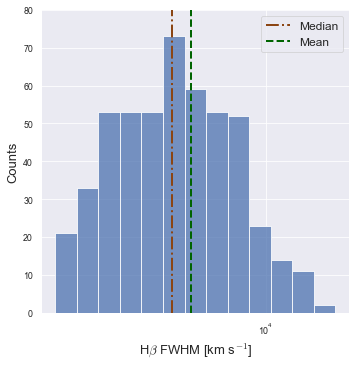

In [19]:
sns.displot(data=qsos, x='fwhm_h_beta', palette='colorblind', log_scale=True)
plt.vlines(qsos['fwhm_h_beta'].median(), 0, 80, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['fwhm_h_beta'].mean(), 0, 80, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 80)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'H$\beta$ FWHM [km s$^{-1}$]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('qsos_Hbeta_fwhm_distr.pdf')

plt.show()

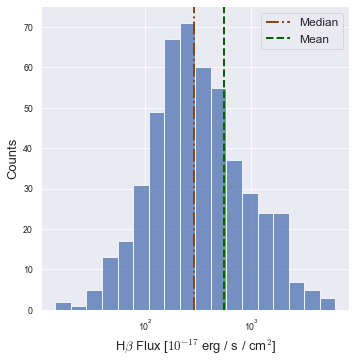

In [20]:
sns.displot(data=qsos, x='h_beta_flux', palette='colorblind', log_scale=True)
plt.vlines(qsos['h_beta_flux'].median(), 0, 75, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['h_beta_flux'].mean(), 0, 75, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 75)

plt.ylabel('Counts', fontsize=13);
plt.xlabel(r'H$\beta$ Flux [$10^{-17}$ erg / s / cm$^2$]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('qsos_Hbeta_flux_distr.pdf')

plt.show()

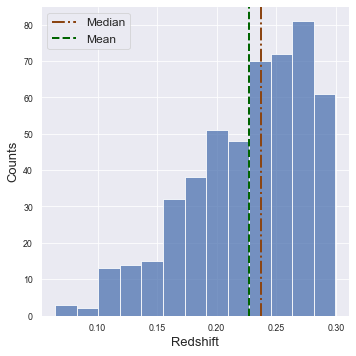

In [21]:
sns.displot(data=qsos, x='redshift', palette='colorblind')
plt.vlines(qsos['redshift'].median(), 0, 85, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['redshift'].mean(), 0, 85, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 85)

plt.ylabel('Counts', fontsize=13);
plt.xlabel('Redshift', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('qsos_z_distr.pdf')

plt.show()

In [22]:
# magnitudes are negative, so I plot them with their absolute value
qsos['iMAG_abs'] = np.abs(qsos['iMAG'])

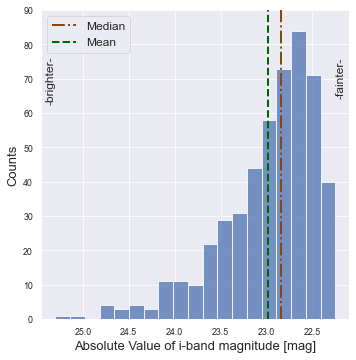

In [23]:
sns.displot(data=qsos, x='iMAG_abs', palette='colorblind')
plt.vlines(qsos['iMAG_abs'].median(), 0, 90, color='saddlebrown', linewidth=2, linestyles='dashdot', label='Median')
plt.vlines(qsos['iMAG_abs'].mean(), 0, 90, color='darkgreen', linewidth=2, linestyles='dashed', label='Mean')
plt.ylim(0, 90)

ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])

plt.text(25.4, 63, '-brighter-', fontsize=12, rotation=90);
plt.text(22.25, 65, '-fainter-', fontsize=12, rotation=90);

plt.ylabel('Counts', fontsize=13);
plt.xlabel('Absolute Value of i-band magnitude [mag]', fontsize=13);
plt.legend(fontsize=12)

# plt.savefig('qsos_iMAG_distr.pdf')

plt.show()

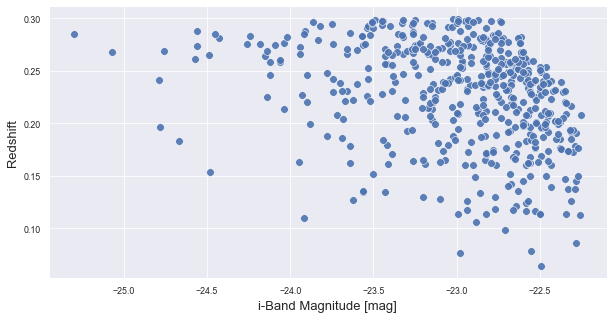

In [24]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='iMAG', y='redshift', palette='colorblind', s=60, alpha=0.9)

plt.xlabel(r'i-Band Magnitude [mag]', fontsize=13);
plt.ylabel('Redshift', fontsize=13);

# plt.savefig('qsos_imag_vs_z.pdf')

plt.show()

In [25]:
qsos[['iMAG', 'redshift', 'fwhm_h_beta']].describe()

,iMAG,redshift,fwhm_h_beta
count,500.00000,500.000000,500.000000
mean,-22.98284,0.226942,4825.009600
std,0.52241,0.049635,2975.763737
min,-25.30000,0.064495,1281.100000
25%,-23.25000,0.193991,2621.675000
50%,-22.84000,0.236845,3997.300000
75%,-22.60000,0.267921,6338.725000
max,-22.25000,0.299768,19717.100000


### Limitations of the Sample

The sample doesn't have even distributions in magnitude or in redshift. The majority of the objects are distant, and their redshift is above the median of 0.237. Similarly, the majority of the objects' i-band magnitude is fainter than their median (-22.84 mag). In other words, the sample has a selection of fainter and more distant QSOs. This might bias the results later on.

#### FWHM

To calculate the Full Width Half Maximum (FWHM) of other lines, I went back to the SDSS Cross-Match tool to download the velocity dispersions $\sigma$ of the lines. The FWHM can be calculated with:
\begin{align}
      \text{FWHM} = 2 \sqrt{ 2 \ln{2} } \times \sigma \approx 2.355 \times \sigma
\end{align}

This is the SQL query I used:

```
SELECT s.plate, s.mjd, s.fiberID, g.sigma_balmer, g.sigma_forbidden
FROM #upload u
      JOIN SpecObjAll s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

In addition to the Balmer series lines, I also downloaded the velocity dispersion for the forbidden lines just in case it comes in handy. The result of this query is in `vel_dispersions.csv`.

---

The most efficient SQL query that downloads all needed information would have been:
```
SELECT s.z AS redshift, g.h_beta_flux, g.sigma_balmer, g.sigma_forbidden
FROM #upload u
      JOIN SpecObjAll as s
      ON (s.plate=u.up_plate AND s.mjd=u.up_mjd AND s.fiberID=u.up_fiber)
      JOIN
      GalSpecLine AS g
      ON g.specobjid = s.specobjid
```

In [26]:
def FWHM(sigma):
    '''
    Full Width Halfh Maximum in [km/s]
    from vel dispersion in [km/s]
    '''
    return 2.355 * sigma

In [27]:
sigmas = pd.read_csv('vel_dispersions.csv', header=1)
sigmas.drop_duplicates(inplace=True)  # there are two identical rows per object
sigmas

,plate,mjd,fiberID,sigma_balmer,sigma_forbidden
0,1045,52725,72,313.062,291.7598
1,1050,52721,500,500.000,245.1475
2,1344,52792,91,500.000,282.8331
3,1346,52822,86,500.000,500.0000
4,1378,53061,574,500.000,206.1464
...,...,...,...,...,...
982,2115,53535,265,500.000,500.0000
983,2160,53885,243,500.000,500.0000
984,2770,54510,433,500.000,500.0000
985,2771,54527,71,500.000,253.8604


In [28]:
# merging with main df again
sigmas.rename(columns={'plate': 'Plate', 'mjd': 'MJD', 'fiberID': 'Fiber'}, inplace=True)
qsos = qsos.merge(sigmas, on=['Plate', 'MJD', 'Fiber'])

In [29]:
qsos.shape[1] == 22 + 2

False

In [30]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'log_Lbol',
       'log_Lbol_error', 'log_broad_L_h_beta', 'log_broad_L_h_beta_error',
       'fwhm_h_beta', 'fwhm_h_beta_error', 'eq_wid_h_beta',
       'eq_wid_h_beta_error', 'sig_noise_h_beta', 'log_BH_mass',
       'log_BH_mass_error', 'logEdd', 'redshift', 'h_beta_flux', 'ra', 'dec',
       'iMAG_abs', 'sigma_balmer', 'sigma_forbidden'],
      dtype='object')

In [31]:
qsos['fwhm_balmer'] = qsos.apply(lambda x: FWHM(x['sigma_balmer']), axis=1)
qsos['fwhm_forbidden'] = qsos.apply(lambda x: FWHM(x['sigma_forbidden']), axis=1)
qsos

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,log_Lbol,log_Lbol_error,log_broad_L_h_beta,log_broad_L_h_beta_error,...,logEdd,redshift,h_beta_flux,ra,dec,iMAG_abs,sigma_balmer,sigma_forbidden,fwhm_balmer,fwhm_forbidden
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,...,-1.20,0.228846,323.90260,189.67803,45.306863,23.20,500.0000,433.6110,1177.500000,1021.153905
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,...,-0.87,0.178252,448.13070,189.77188,41.445637,22.29,500.0000,291.3802,1177.500000,686.200371
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,...,-2.03,0.201624,86.80108,189.81417,53.237400,22.69,288.9515,397.9982,680.480783,937.285761
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,...,-2.33,0.239360,370.09130,189.93734,19.907090,23.37,226.5555,209.3104,533.538203,492.925992
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,...,-0.23,0.235311,589.24180,189.99405,49.094498,22.77,414.4889,117.9253,976.121360,277.714081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,231.08040,27.95578,1846,28,54173,-23.33,45.423,0.005,42.56,0.02,...,-1.76,0.284370,118.15860,231.08041,27.955782,23.33,500.0000,152.5751,1177.500000,359.314360
496,231.09229,26.70657,2160,444,53885,-22.72,44.989,0.005,42.19,0.04,...,-1.31,0.236137,324.73740,231.09229,26.706561,22.72,500.0000,338.4847,1177.500000,797.131468
497,231.11946,30.54376,1650,545,53174,-24.56,45.891,0.001,43.14,0.01,...,-0.40,0.273973,2162.26000,231.11947,30.543761,24.56,500.0000,383.8575,1177.500000,903.984413
498,231.12225,35.25613,1354,466,52814,-22.60,45.143,0.005,41.80,0.05,...,-0.34,0.249451,252.49410,231.12225,35.256130,22.60,434.0521,212.5933,1022.192696,500.657221


In [32]:
qsos.columns

Index(['RAJ2000', 'DEJ2000', 'Plate', 'Fiber', 'MJD', 'iMAG', 'log_Lbol',
       'log_Lbol_error', 'log_broad_L_h_beta', 'log_broad_L_h_beta_error',
       'fwhm_h_beta', 'fwhm_h_beta_error', 'eq_wid_h_beta',
       'eq_wid_h_beta_error', 'sig_noise_h_beta', 'log_BH_mass',
       'log_BH_mass_error', 'logEdd', 'redshift', 'h_beta_flux', 'ra', 'dec',
       'iMAG_abs', 'sigma_balmer', 'sigma_forbidden', 'fwhm_balmer',
       'fwhm_forbidden'],
      dtype='object')

### H $\beta$ Luminosity

Next up, I'll try and find the luminosity of the H $\beta$ line.

First, I'll calculate the luminosity distance $D_L$ using a simple cosmological model from __[`astropy`](https://docs.astropy.org/en/stable/index.html)__.

In [33]:
# cosmological constants
H0 = 67.8  # km / s Mpc
Omega_m = 0.31  # Matter density parameter
Omega_l = 0.69  # Dark energy density parameter

In [34]:
# astropy.cosmology for the luminosity distance
cosmo = FlatLambdaCDM(H0=H0 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=Omega_m)

In [35]:
D_Ls = cosmo.luminosity_distance(qsos['redshift'])
D_Ls  # in Mpc

<Quantity [1175.10239108,  889.10182071, 1019.51837712, 1236.22526889,
           1212.61632755, 1214.37128809,  964.48930188,  790.76709941,
           1201.82735012,  815.09985814,  967.45018781, 1240.87670497,
           1294.77297817, 1375.84377434, 1242.72976706, 1486.92066416,
           1161.82242278, 1382.67951026,  973.44538514, 1439.3851282 ,
           1084.4651613 , 1049.60520548, 1392.41424251, 1419.54254503,
            800.85638954,  806.05363879,  735.44851732, 1200.25232751,
            909.84229149, 1488.09458768,  945.34555698, 1440.55280425,
           1018.4349768 , 1396.45598442, 1236.80469588, 1312.09319998,
            611.98944253, 1048.71596038, 1338.89647652,  986.00652138,
           1572.13812807, 1432.13488533, 1347.79437041, 1064.80378005,
           1218.13540371, 1239.53370197,  792.42571306, 1443.70200013,
           1391.93695966,  920.81597032,  696.73778185, 1329.13824936,
           1192.63645161, 1295.09878323, 1445.05326959, 1509.32433588,
      

In [36]:
qsos['lum_dist'] = np.asarray(D_Ls)

Next, I'll calculate the luminosity of the H$\beta$ line. From the formula found in __[Hogg 2000](https://arxiv.org/abs/astro-ph/9905116)__:
\begin{align}
    \nu S_{\nu} = \frac{\nu_e L_{\nu_e}}{4 \pi {D_L}^2}
\end{align}

This is formula number 24 in the paper. $S_{\nu}$ is the differential flux at frequency $\nu$, $\nu_e = (1 + z) \nu$ is the emitted frequency, and $L_{\nu_e}$ is thedifferential luminosity at frequency $\nu$.

I can obtain the luminosity $L_{\nu_e}$:
\begin{align}
    L_{\nu_e} = 4 \pi {D_L}^2 S_{\nu} \frac{1}{(1 + z)}
\end{align}

In [37]:
def L_from_D_L(D_L, flux, redshift):
    '''
    Formula #24 from Hogg 2000
    Solved for luminosity

    Inputs:
    D_L: luminosity distance in Mpc
    flux: in 1e-17 erg / (s cm^2)
    redshift: dimensionless

    Output:
    Luminosity in erg / s
    '''

    # 1 pc = 3.0857e16 meters = 3.0857e18 centimeters
    D_L_cm = D_L * 1e6 *3.0857e18

    return 4 * np.pi * D_L_cm**2 * (flux * 1e-17) / (1 + redshift)

In [39]:
# prefix my_ is so that I can distinguish between given and calculated values
qsos['my_L_h_beta'] = qsos.apply(lambda x: L_from_D_L(x['lum_dist'], x['h_beta_flux'], x['redshift']), axis=1)
qsos['my_log_L_h_beta'] = np.log10(qsos['my_L_h_beta'])
qsos[['my_L_h_beta', 'my_log_L_h_beta']].describe()

,my_L_h_beta,my_log_L_h_beta
count,5.000000e+02,500.000000
mean,6.002269e+41,41.589856
std,7.029190e+41,0.402436
min,2.246757e+40,40.351556
25%,2.125899e+41,41.327540
50%,3.926674e+41,41.594014
75%,7.311513e+41,41.864006
max,6.700309e+42,42.826095


I can quickly compare my obtained value for the luminosity of the H $\beta$ line with the one provided in the sample:

In [40]:
qsos[['log_broad_L_h_beta', 'my_log_L_h_beta']].describe()

,log_broad_L_h_beta,my_log_L_h_beta
count,500.000000,500.000000
mean,42.316980,41.589856
std,0.338659,0.402436
min,40.680000,40.351556
25%,42.120000,41.327540
50%,42.300000,41.594014
75%,42.500000,41.864006
max,43.420000,42.826095


/Users/nicolasgalvarinoguerravaras/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


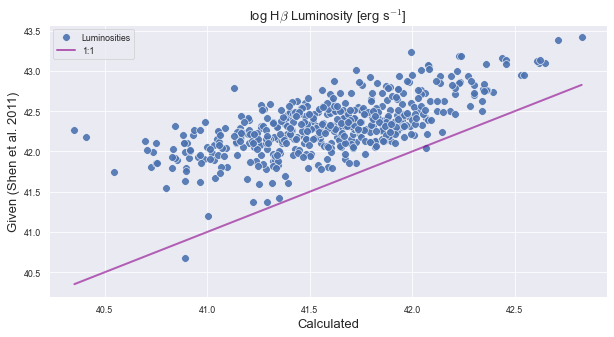

In [64]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='my_log_L_h_beta', y='log_broad_L_h_beta', palette='colorblind', 
                s=60, alpha=0.9, label='Luminosities')

x_to_plot = np.linspace(qsos['my_log_L_h_beta'].min(), qsos['my_log_L_h_beta'].max(), 50)
sns.lineplot(x_to_plot, x_to_plot, linewidth=2, color='darkmagenta', label='1:1', alpha=0.6)

plt.xlabel(r'Calculated', fontsize=13);
plt.ylabel('Given (Shen et al. 2011)', fontsize=13);
plt.title(r'log H$\beta$ Luminosity [erg s$^{-1}$]', fontsize=13);

# plt.savefig('calculated_vs_given_Hbeta_lum.pdf')

plt.show()

I note that my calculated values are systematically lower than the given ones. This might be because of the luminosity distance. It might be an underestimation of the true distance to the object, which results in a lower luminosity.

### BH Mass with Empirical Relation

__[Wu 2009](http://adsabs.harvard.edu/abs/2009MNRAS.398.1905W)__, presents relations to calculate black hole (BH) masses, Eddington ratios and possible relations between [OIII] kinematics and the accretion and jet properties. These are valid for a specific type of AGN: GHz-peaked-spectrum (GPS) and compact steep-spectrum (CSS) radio sources, which are compact radio galaxies. Their spectra have a peak at ~1 GHz and ~1000 GHz respectively.

The sample presented in the paper is not a complete sample of radio galaxies. Instead, the author focused on making it characteristic of these kind of objects. The redshift distribution of this sample differs from the one used in this tutorial, as it goes from ~0.1 to ~3.5, whilst the sample analysed here has redshift below 0.30. In addition, radio galaxies may not necessarily be QSOs, so the type of AGN in both samples is not quite the same.

In Section 3.1, estimations for the BH mass are presented. Assuming that the gas around the BH is virialised, i.e. gravitationally bound to the BH, the BH mass can be estimated as:
\begin{align}
    M_{BH} = \frac{R_{BLR} V^2}{G},
\end{align}

where $R_{BLR}$ is the size of the broad line region (BLR), which is assumed to be isotropic, $V$ is estimated from the FWHM of a broad emission line and $G$ is the gravitational constant. 


\begin{align}
    M_{BH} = 2.4 \times 10^6 \left ( \frac{L_{ \text{H} \beta }}{10^{42} \text{ erg s}^{-1} } \right )^{0.59} \left ( \frac{ \text{FWHM}_{ \text{H} \beta } }{ 10^3 \text{ km s}^{-1} } \right )^2 M_{\odot}
\end{align}

In [43]:
def M_BH_Wu(L_h_beta, fwhm_h_beta):
    '''
    Formula #2 from Wu 2009

    Inputs:
    L_h_beta: luminosity of H beta line in erg / s
    fwhm_h_beta: FWHM of H beta line in km / s
    redshift: dimensionless

    Output:
    Black hole mass in solar masses
    '''
    return 2.4e6 * (L_h_beta / 1e42)**0.59 * (fwhm_h_beta / 1e3)**2

In [44]:
qsos['Wu_BH_mass'] = qsos.apply(lambda x: M_BH_Wu(x['my_L_h_beta'], x['fwhm_h_beta']), axis=1)
qsos['log_Wu_BH_mass'] = np.log10(qsos['Wu_BH_mass'])
qsos[['Wu_BH_mass', 'log_Wu_BH_mass']].describe()  # good estimates!

,Wu_BH_mass,log_Wu_BH_mass
count,5.000000e+02,500.000000
mean,3.449238e+07,7.360635
std,3.964221e+07,0.391132
min,2.256199e+06,6.353377
25%,1.201070e+07,7.079568
50%,2.408917e+07,7.381822
75%,4.256800e+07,7.629081
max,3.901372e+08,8.591217


/Users/nicolasgalvarinoguerravaras/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


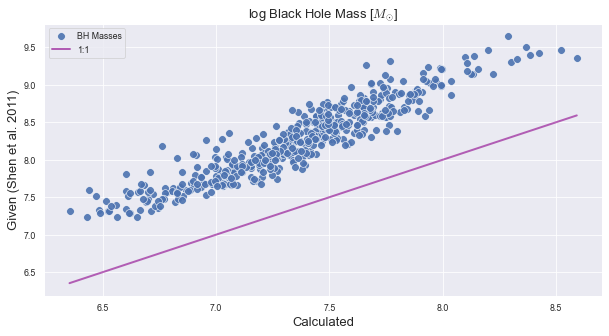

In [62]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='log_Wu_BH_mass', y='log_BH_mass', palette='colorblind', 
                s=60, alpha=0.9, label='BH Masses')

x_to_plot = np.linspace(qsos['log_Wu_BH_mass'].min(), qsos['log_Wu_BH_mass'].max(), 50)
sns.lineplot(x_to_plot, x_to_plot, linewidth=2, color='darkmagenta', label='1:1', alpha=0.6)

plt.xlabel(r'Calculated', fontsize=13);
plt.ylabel('Given (Shen et al. 2011)', fontsize=13);
plt.title(r'log Black Hole Mass [$M_{\odot}$]', fontsize=13);

# plt.savefig('calculated_vs_given_Wu_BH_Mass.pdf')

plt.show()

I note that once again my calculated values are systematically lower than the given ones. It is because my estimates of the luminosity are lower than the given values (see previous plot). However, the estimated values range from $10^{6.35} M_{\odot}$ up to $10^{8.59} M_{\odot}$, which are well within the expected masses of a supermassive BH (SMBH): $10^{6} M_{\odot}$ up to $10^{10} M_{\odot}$. Thus, this estimate is sound.

### Bolometric Luminosity

I'll estimate the bolometric luminosity using equation 8 of the paper:
\begin{align}
    \log{L_{bol}} = \left ( 0.94 \pm 0.03 \right) \log{L_{ \text{H}\beta }} + (5.39 \pm 1.14)
\end{align}

This equation assumes that:
* $ L_{bol} = 9 L_{5100} $, where $L_{5100}$ is the monochromatic luminosity at $5100$ Ang.
* the galaxies are radio quiet, and thus, their optical thermal emission is not contaminated by non-thermal synchrotron emission.

It is specially useful for sources whose emission is likely contaminated by the beam of relativistic jets.

In [52]:
def log_Lbol_Wu(log_L_h_beta):
    '''
    Formula #8 from Wu 2009

    Input:
    log_L_h_beta: log of the luminosity of H beta line in erg / s

    Output:
    log of the bolometric luminosity in erg / s
    '''
    return 0.94 * log_L_h_beta + 5.39

In [53]:
qsos['Wu_log_Lbol'] = qsos.apply(lambda x: log_Lbol_Wu(x['my_log_L_h_beta']), axis=1)
qsos[['Wu_log_Lbol', 'log_Lbol']].describe()

,Wu_log_Lbol,log_Lbol
count,500.000000,500.000000
mean,44.484465,45.231022
std,0.378290,0.213591
min,43.320463,44.818000
25%,44.237887,45.088000
50%,44.488373,45.189500
75%,44.742165,45.330500
max,45.646529,46.118000


/Users/nicolasgalvarinoguerravaras/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


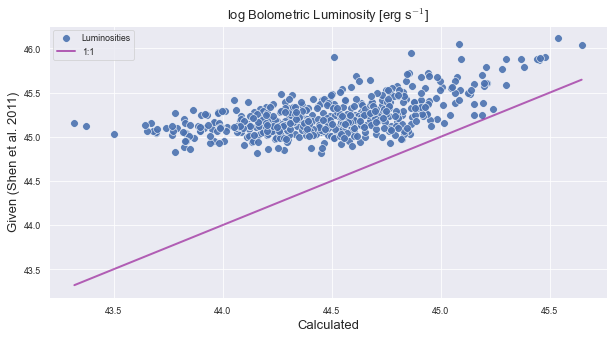

In [61]:
f, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=qsos, x='Wu_log_Lbol', y='log_Lbol', palette='colorblind', 
                s=60, alpha=0.9, label='Luminosities')

x_to_plot = np.linspace(qsos['Wu_log_Lbol'].min(), qsos['Wu_log_Lbol'].max(), 50)
sns.lineplot(x_to_plot, x_to_plot, linewidth=2, color='darkmagenta', label='1:1', alpha=0.6)

plt.xlabel(r'Calculated', fontsize=13);
plt.ylabel('Given (Shen et al. 2011)', fontsize=13);
plt.title(r'log Bolometric Luminosity [erg s$^{-1}$]', fontsize=13);

# plt.savefig('calculated_vs_given_Wu_Lbol.pdf')

plt.show()

The estimates have reasonable values, as they are in the same order of magnitude as the given values. Wu et al. 2009 mentions that the values obtained from this empirical formula are expected to be to be 3 times larger than the ones used with this popular relation:
\begin{align}
    L_{bol} = 10 L_{BLR} = 252.6 L_{ \text{H}\beta }
\end{align}

(maybe check later)

## Bulge Luminosity of the Host Galaxy